In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from collections import Counter
from sklearn import ensemble,model_selection,metrics,feature_selection
import xgboost
import lightgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pyecharts import Bar,Line,Overlap,Grid,Page
import graphviz 
import os
from sklearn import tree
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
sns.set(style='whitegrid')
from sklearn.cluster import KMeans
from sklearn import datasets
import sys
sys.path.append('F:/github/Code_Library')
from bestbinning_entropy_gini import get_bestsplit_list,EntropyGiniBinning
from sklearn import linear_model,svm,neighbors,neural_network
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题-设置字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

## data import

In [ ]:
iris = datasets.load_iris()
iris_x = iris.get('data')
iris_y = iris.get('target')
iris_feature_names = iris.get('feature_names')

In [ ]:
breast = datasets.load_breast_cancer()
breast_x = breast.get('data')
breast_y = breast.get('target')
breast_feature_names = breast.get('feature_names')

In [98]:
train_kj = pd.read_csv('./train_kj.csv',encoding='gbk',dtype=str)
test_kj = pd.read_csv('./test_kj.csv',encoding='gbk',dtype=str)

### size count and bad ratio、plot

In [241]:
a,b = feature_count_ratio(data=train_kj,x='age',xtype='numeric',y='FPD30',value='LOAN_NO')

In [227]:
a,b = feature_count_ratio(data=train_kj,x='channel',xtype='cate',y='FPD30',value='LOAN_NO')

In [165]:
a,b = feature_count_ratio(data=train_kj,x='loan_amt',xtype='numeric',y='FPD30',value='LOAN_NO')

In [223]:
a,b = feature_count_ratio(data=train_kj,x='nation',xtype='cate',y='FPD30',value='LOAN_NO')

In [220]:
a,b = feature_count_ratio(data=train_kj,x='unit_prov',xtype='cate',y='FPD30',value='LOAN_NO')

In [268]:
a,b=get_woe_iv(df=train_kj,x='nation',x_type='cate',y='FPD30',style=True,sort=True)

total IV of nation is: 0.018277054524970828


### best split test

In [ ]:
bsg = EntropyGiniBinning()

In [ ]:
%%time
bsg.split_numeric(data=train_kj, feature='loan_amt', target='FPD30',min_samples_leaf=train_kj.shape[0]*0.05)

In [3]:
%%time
get_bestsplit_list(sample_set=train_kj.rename(columns={'FPD30':'target'}),var='loan_amt')

SyntaxError: invalid syntax (<ipython-input-3-279a39e15bea>, line 3)

In [45]:
bsp = BestSplitGini()

bsp.get_bestsplit_list(sample_set=train_kj[['income','FPD30','age','mth_repay_amt']].astype(float).rename(columns={'FPD30':'target'}),var='mth_repay_amt',p=0.05)

### tree visualization

In [112]:
labe = LabelEncoder()

train_kj['education_c'] = labe.fit_transform(train_kj[['education']])

In [116]:
train_kj['education_c']=train_kj['education_c'].astype('category')

In [156]:
dt = tree.DecisionTreeClassifier(criterion='entropy',min_samples_leaf=round(train_kj.shape[0]*0.05))

In [157]:
dt.fit(pd.get_dummies(train_kj[['education']]),train_kj['FPD30'])

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=826, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [9]:
dt = tree.DecisionTreeClassifier(criterion='entropy',max_depth=3)

In [13]:
dt.fit(train_kj[['loan_amt']].as_matrix(),train_kj['FPD30'].values)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [22]:
def tree_visualization(dt,x_list):
    '''决策树可视化'''
    dot_data = tree.export_graphviz(dt, out_file=None, feature_names = x_list, class_names = True, filled = True, rounded = True)
    return graphviz.Source(dot_data)

### KMeans

#### --k 

In [150]:
def kmeans_k_confirm(x_array,k_range=range(1,9)):
    inertias = []
    clusters = {}
    for k in k_range:
        kms = KMeans(n_clusters=k).fit(x_array)
        inertias.append(kms.inertia_)
        clusters[k] = kms.predict(x_array)
    plt.plot([i for i in k_range],inertias,'ro-')
    plt.ylabel('Inertia')
    plt.xlabel('K')
    plt.title('KMeans Inertia Decrease')
    return inertias, clusters

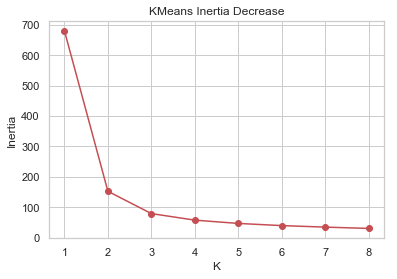

In [151]:
inertias_t,clusters = kmeans_k_confirm(x_array=iris_x)

In [181]:
inertias_t

[681.3706,
 152.34795176035792,
 78.85144142614601,
 57.228473214285714,
 46.44618205128205,
 39.23730158730159,
 34.29822966507177,
 29.990426406926414]

In [154]:
def kmeans_k_scatter(clusters):
    palette=['r','b','g','y','black','orange','violet','brown']
    pca_results = PCA(n_components=2).fit_transform(iris_x)
    plt.figure(figsize=(20,8))
    n=1
    for k, hue in clusters.items():
        plt.subplot(2,4,n)
        g = sns.scatterplot(x=pca_results[:,0], y=pca_results[:,1], hue=hue, palette=palette[:k], legend=False)
        g.set_title('K=%s'%k)
        n+=1

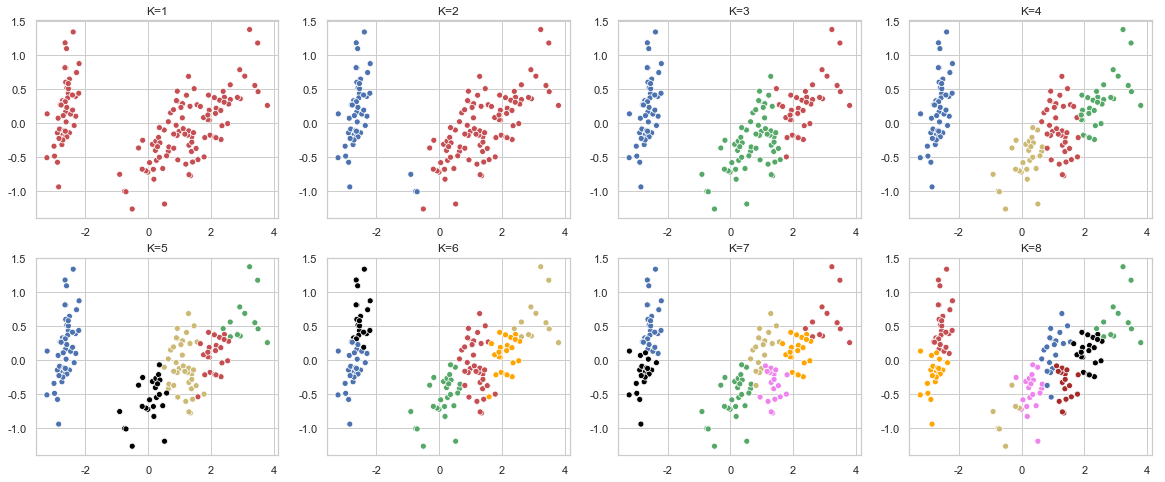

In [156]:
kmeans_k_scatter(clusters=clusters)

#### --Initial center

In [193]:
init_points = initCentroids(dataSet=iris_x,k=3)

In [197]:
init_points

array([[4.4, 3.2, 1.3, 0.2],
       [7.7, 2.6, 6.9, 2.3],
       [4.9, 2.5, 4.5, 1.7]])

In [186]:
kmms = KMeans(n_clusters=3,init=init_points)

In [187]:
kmms.fit(iris_x)

KMeans(algorithm='auto', copy_x=True,
       init=array([[5. , 3.5, 1.3, 0.3],
       [7.7, 2.6, 6.9, 2.3],
       [4.9, 2.5, 4.5, 1.7]]),
       max_iter=300, n_clusters=3, n_init=10, n_jobs=None,
       precompute_distances='auto', random_state=None, tol=0.0001, verbose=0)

In [171]:
#初始聚类中心改进算法
# from numpy import *
# calculate Euclidean distance
def euclDistance(vector1, vector2):
    return np.sqrt(sum(np.power(vector2 - vector1, 2)))#平方，求和，开方
 
# init centroids with random samples 随机初始质心
def initCentroids(dataSet, k):
    numSamples, dim = dataSet.shape#求行列数
    centroids = np.zeros((k, dim))#创建空矩阵，放初始点
    #第一个点
    index = int(np.random.uniform(0, numSamples))
    centroids[0, :] = dataSet[index, :]
    #第二个点
    A1=np.mat(np.zeros((numSamples, 1)))
    for i in range(numSamples):
        distance = euclDistance(centroids[0, :], dataSet[i, :])
        A1[i] = distance
    centroids[1, :]= dataSet[np.nonzero(A1[:, 0] == max(A1))[0]]
    
    #第三个点及以后，
    #然后再选择距离前两个点的最短距离最大的那个点作为第三个初始类簇的中心点，
    j = 1
    while j<=k-2:
        mi = np.mat(np.zeros((numSamples, 1)))
        for i in range(numSamples):
            distance1 = euclDistance(centroids[j-1, :], dataSet[i-1, :])
            distance2 = euclDistance(centroids[j, :], dataSet[i-1, :])
            mi[i-1] = min([distance1,distance2])
        centroids[1+j, :]= dataSet[np.nonzero(mi[:, 0] == max(mi))[0]]
        j=j+1
    return centroids
 
# k-means cluster
def kmeans(dataSet, k):
    numSamples = dataSet.shape[0]#行数
    # first column stores which cluster this sample belongs to,
    # second column stores the error between this sample and its centroid
    clusterAssment = np.mat(np.zeros((numSamples, 2)))
    clusterChanged = True
 
    ## step 1: init centroids
    centroids = initCentroids(dataSet, k)#调用初始化质心函数
 
    while clusterChanged:
        clusterChanged = False
        ## for each sample
        for i in range(numSamples):
            minDist  = 100000.0
            minIndex = 0
            ## for each centroid
            ## step 2: find the centroid who is closest
            for j in range(k):
                distance = euclDistance(centroids[j, :], dataSet[i, :])#调用前面的函数
                if distance < minDist:
                    minDist  = distance
                    minIndex = j
                    
            ## step 3: update its cluster
            if clusterAssment[i, 0] != minIndex:
                clusterChanged = True
                clusterAssment[i, :] = minIndex, minDist**2
 
        ## step 4: update centroids
        for j in range(k):
            #找出每一类的点
            pointsInCluster = dataSet[np.nonzero(clusterAssment[:, 0].A == j)[0]]
            #clusterAssment[:, 0].A == j测试所有数据的类相同为true不同为false
            #np.nonzero()[0]把所有为true的位置写出来
            #pointsInCluster = dataSet[np.nonzero(clusterAssment[:, 0] == j)[0]]  .A的作用目前不清楚，不加也一样
            #求每一类的中心店
            centroids[j, :] = mean(pointsInCluster, axis = 0)
            
    print('Congratulations, cluster complete!')
    return centroids, clusterAssment
 
# show your cluster only available with 3-D data
def showCluster(dataSet, k, centroids, clusterAssment):
    numSamples, dim = dataSet.shape
    if dim > 3:
        print("Sorry! I can not draw because the dimension of your data is not 3!")
        return 1
 
    mark = ['r', 'g', 'b', 'y', 'm', 'k']
    if k > len(mark):
        print("Sorry! Your k is too large! please contact Zouxy")
        return 1
    
    fig = plt.figure()
    ax = plt.subplot(111, projection='3d')
    
    # draw all samples
    for i in range(numSamples):
        markIndex = int(clusterAssment[i, 0])
        ax.scatter(dataSet[i, 0], dataSet[i, 1], dataSet[i, 2], c=mark[markIndex], s=10)
   
    mark = ['r', 'b', 'g', 'k', 'm', 'y']
    # draw the centroids
    for i in range(k):
        ax.scatter(centroids[i, 0], centroids[i, 1], dataSet[i, 2], c=mark[3],s=100)
        #plt.plot(centroids[i, 0], centroids[i, 1], mark[i], markersize = 12)

### feature importance

In [359]:
def feature_importance_ensemble(x_array,y_array,xName_list,n_estimators=100, max_depth=3,figsize=(22,8)):
    xgbc = xgboost.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth)
    lgbc = lightgbm.LGBMClassifier(n_estimators=n_estimators, max_depth=max_depth)
    rfc = ensemble.RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    xgbc.fit(X=x_array,y=y_array)
    lgbc.fit(X=x_array,y=y_array)
    rfc.fit(X=x_array,y=y_array)
    xgbc_imp = pd.Series(xgbc.feature_importances_,index=xName_list,name='importance_xgbc')
    lgbc_imp = pd.Series(lgbc.feature_importances_,index=xName_list,name='importance_lgbc')
    rfc_imp = pd.Series(rfc.feature_importances_,index=xName_list,name='importance_rfc')
    imp_df=pd.concat([xgbc_imp,lgbc_imp,rfc_imp],axis=1)
    for i in ['importance_xgbc','importance_lgbc','importance_rfc']:
         imp_df['rank_'+i.split('_')[1]] = imp_df[i].rank(ascending=False)
    imp_df['rank_Total'] = imp_df[['rank_xgbc','rank_lgbc','rank_rfc']].sum(axis=1).rank()
    imp_df = imp_df.sort_values('rank_Total')
    # 重要性图
    plt.figure(figsize=figsize)
    n=1
    for i in ['importance_xgbc','importance_lgbc','importance_rfc']:
        plt.subplot(1,3,n)
        g = sns.barplot(y=imp_df.index, x=imp_df[i].values)
        g.set_title(i)
        if n==1:
            g.set_ylabel('Total Importances Ranking')
        n+=1
    return imp_df

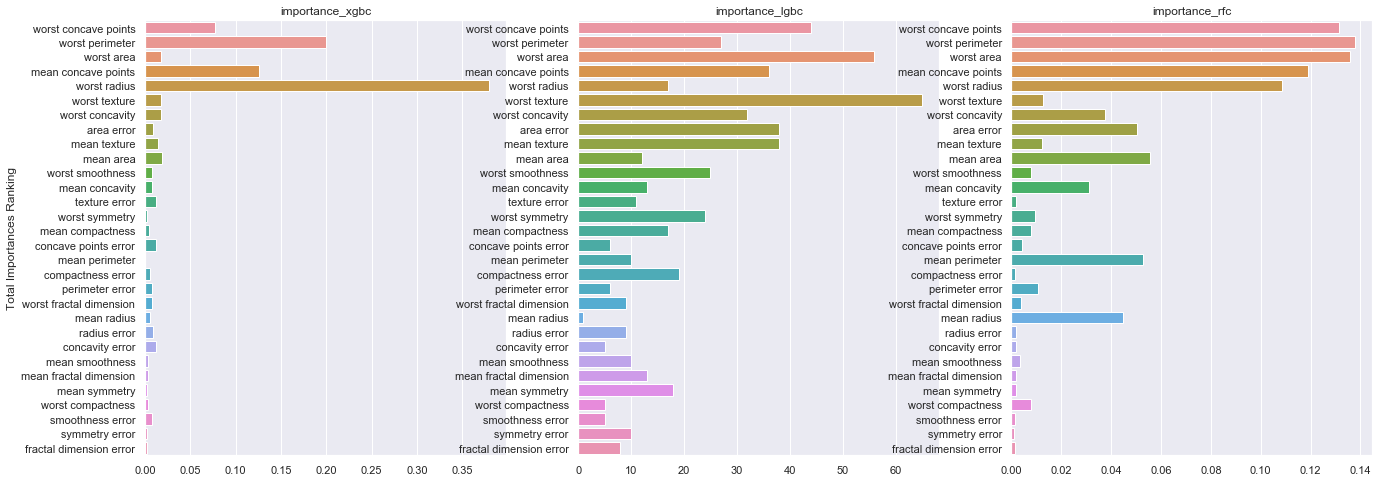

In [360]:
imp_t = feature_importance_ensemble(breast_x,breast_y,breast_feature_names)

### KFold and StratifiedKFold

In [309]:
xgbc = xgboost.XGBClassifier(n_estimators=100, max_depth=3)
lgbc = lightgbm.LGBMClassifier(n_estimators=100, max_depth=3)
rfc = ensemble.RandomForestClassifier(n_estimators=400, max_depth=6)

In [206]:
kf = model_selection.KFold(n_splits=5,shuffle=True,random_state=None)

skf = model_selection.StratifiedKFold(n_splits=5,shuffle=True,random_state=4)

In [430]:
def model_init(reDefine_clf = {},used_clf=[]):
    clfs = {'xgb':xgboost.XGBClassifier(n_estimators=100, max_depth=3),
            'lgb':lightgbm.LGBMClassifier(n_estimators=100, max_depth=3),
            'gbdt':ensemble.GradientBoostingClassifier(n_estimators=100, max_depth=3),
            'rf':ensemble.RandomForestClassifier(n_estimators=200, max_depth=6),
            'logit':linear_model.LogisticRegression(),
            'svc':svm.SVC(probability=True),
            'adbt':ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=3)),
            'bagg':ensemble.BaggingClassifier(n_estimators=100),
            'ext':ensemble.ExtraTreesClassifier(n_estimators=100,max_depth=3),
            #   'perceptron':linear_model.Perceptron(),
            'dt':tree.DecisionTreeClassifier(),
            'knn':neighbors.KNeighborsClassifier(),
            'network':neural_network.MLPClassifier()}
    clfs.update(reDefine_clf) if reDefine_clf else clfs
    if used_clf:
        return dict((key, value) for key, value in clfs.items() if key in used_clf)
    else:
        return clfs

In [423]:
xgb = xgboost.XGBClassifier(n_estimators=400, max_depth=2)

In [389]:
dt = tree.DecisionTreeClassifier(max_depth=9,min_samples_leaf=4)

In [428]:
%%time
clf_list = model_init(redefine_clf={'dt':dt,'xgb':xgb})

Wall time: 0 ns


In [403]:
%%time
auc_df = model_choose(clf_list,train_back=True)

Wall time: 701 ms


In [404]:
auc_df

,train_mean,test_mean,auc_diff,train_std,test_std
xgb,1.000000,0.993511,0.006489,0.000000,0.005539
lgb,1.000000,0.993308,0.006692,0.000000,0.004849
dt,0.998874,0.952490,0.046384,0.000238,0.019178


In [431]:
def model_choose(clfs,contain_train=True):
    auc_df = pd.DataFrame()
    for clf_name,clf in clfs.items():
        if train_back:
            train_auc,test_auc=[],[]
            for train_index, test_index in skf.split(X=breast_x, y=breast_y):
                trainX,trainY,testX,testY = breast_x[train_index],breast_y[train_index],breast_x[test_index],breast_y[test_index]
                clf.fit(X=trainX,y=trainY)
                train_prob = clf.predict_proba(trainX)[:,1]
                test_prob = clf.predict_proba(testX)[:,1]
                train_auc.append(metrics.roc_auc_score(trainY,train_prob))
                test_auc.append(metrics.roc_auc_score(testY,test_prob))
            auc_df.loc[clf_name,'train_mean'] = np.array(train_auc).mean()
            auc_df.loc[clf_name,'test_mean'] = np.array(test_auc).mean()
            auc_df.loc[clf_name,'auc_diff'] = auc_df.loc[clf_name,'train_mean'] - auc_df.loc[clf_name,'test_mean']
            auc_df.loc[clf_name,'train_std'] = np.array(train_auc).std()
            auc_df.loc[clf_name,'test_std'] = np.array(test_auc).std()
        else:
            scores = model_selection.cross_val_score(estimator=clf,X=breast_x,y=breast_y,cv=skf.split(X=breast_x, y=breast_y),scoring='roc_auc',n_jobs=-1)
            auc_df.loc[clf_name,'test_mean'] = scores.mean()
            auc_df.loc[clf_name,'test_std'] = scores.std()
    return auc_df

In [9]:
class ModelChoose():
    def __init__(self):
        pass
    def model_init(self,reDefine_clf = {},used_clf=[]):
        clfs = {'xgb':xgboost.XGBClassifier(n_estimators=100, max_depth=3),
                'lgb':lightgbm.LGBMClassifier(n_estimators=100, max_depth=3),
                'gbdt':ensemble.GradientBoostingClassifier(n_estimators=100, max_depth=3),
                'rf':ensemble.RandomForestClassifier(n_estimators=200, max_depth=6),
                'logit':linear_model.LogisticRegression(),
                'svc':svm.SVC(probability=True),
                'adbt':ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=3)),
                'bagg':ensemble.BaggingClassifier(n_estimators=100),
                'ext':ensemble.ExtraTreesClassifier(n_estimators=100,max_depth=3),
                #   'perceptron':linear_model.Perceptron(),
                'dt':tree.DecisionTreeClassifier(),
                'knn':neighbors.KNeighborsClassifier(),
                'network':neural_network.MLPClassifier()}
        clfs.update(reDefine_clf) if reDefine_clf else clfs
        if used_clf:
            return dict((key, value) for key, value in clfs.items() if key in used_clf)
        else:
            return clfs
    def model_auc(self,clfs,X_array,y_array,contain_train=True,Stratified=True,n_splits=5):
        if Stratified:
            KF = model_selection.StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=6)
        else:
            KF = model_selection.KFold(n_splits=n_splits,shuffle=True,random_state=8)
        auc_dfs = pd.DataFrame()
        for clf_name,clf in clfs.items():
            if contain_train:
                train_auc,test_auc=[],[]
                for train_index, test_index in KF.split(X=X_array, y=y_array):
                    trainX,trainY,testX,testY = X_array[train_index],y_array[train_index],X_array[test_index],y_array[test_index]
                    clf.fit(X=trainX,y=trainY)
                    train_prob = clf.predict_proba(trainX)[:,1]
                    test_prob = clf.predict_proba(testX)[:,1]
                    train_auc.append(metrics.roc_auc_score(trainY,train_prob))
                    test_auc.append(metrics.roc_auc_score(testY,test_prob))
                auc_dfs.loc[clf_name,'train_mean'] = np.array(train_auc).mean()
                auc_dfs.loc[clf_name,'test_mean'] = np.array(test_auc).mean()
                auc_dfs.loc[clf_name,'auc_diff'] = auc_dfs.loc[clf_name,'train_mean'] - auc_dfs.loc[clf_name,'test_mean']
                auc_dfs.loc[clf_name,'train_std'] = np.array(train_auc).std()
                auc_dfs.loc[clf_name,'test_std'] = np.array(test_auc).std()
            else:
                scores = model_selection.cross_val_score(estimator=clf,X=X_array,y=y_array,cv=KF.split(X=X_array, y=y_array),scoring='roc_auc',n_jobs=-1)
                auc_dfs.loc[clf_name,'test_mean'] = scores.mean()
                auc_dfs.loc[clf_name,'test_std'] = scores.std()
        return auc_dfs

In [10]:
mc = ModelChoose()

In [11]:
clfs = mc.model_init()

In [ ]:
clfs = mc.model_init(reDefine_clf={'svc':})

In [13]:
%%time
auc_df = mc.model_auc(clfs=clfs,X_array=breast_x,y_array=breast_y)

Wall time: 7.61 s


In [20]:
auc_df.style.bar()

,train_mean,test_mean,auc_diff,train_std,test_std
xgb,1,0.99218,0.00782031,0,0.00462853
lgb,1,0.993521,0.00647893,0,0.00540081
gbdt,1,0.991044,0.00895554,4.96507e-17,0.00648175
rf,0.999988,0.988896,0.0110918,2.49144e-05,0.00626949
logit,0.994598,0.990754,0.00384452,0.00104198,0.00575964
svc,1,0.934162,0.0658377,0,0.0212106
adbt,1,0.993228,0.0067719,0,0.0052198
bagg,1,0.986614,0.013386,0,0.00791962
ext,0.992152,0.988138,0.00401366,0.00144809,0.00533505
dt,1,0.914279,0.0857205,0,0.0276334


### grid search

In [28]:
params = {'learning_rate':0.1, 'n_estimators':100,
            'boosting_type':'gbdt', 'num_leaves':31, 'max_depth':-1,
             'subsample_for_bin':200000, 
             'min_split_gain':0.0, 'min_child_weight':0.001, 'min_child_samples':20, 
             'subsample':1.0, 'subsample_freq':0, 'colsample_bytree':1.0, 
             'reg_alpha':0.0, 'reg_lambda':0.0}

In [27]:
lgb = lightgbm.LGBMClassifier(**params)

In [30]:
KF = model_selection.StratifiedKFold(n_splits=5,random_state=2,shuffle=True)

In [246]:
param_grid={'max_depth':[3,6,9],'num_leaves':[8,31,62]}

In [251]:
param_grid={'max_depth':[5,6,7],'num_leaves':[3,8,16]}

In [254]:
param_grid={'max_depth':[4,5,6],'num_leaves':[12,16,21]}

In [258]:
param_grid={'max_depth':[5],'num_leaves':[14,16,18]}

In [261]:
param_grid={'max_depth':[5],'num_leaves':[15,16,17]}

In [97]:
%%time
gs=model_selection.GridSearchCV(estimator=lgb,param_grid=param_grid,scoring='roc_auc',n_jobs=-1,cv=KF.split(breast_x,breast_y))
gs.fit(breast_x,breast_y)

Wall time: 2.44 s


In [264]:
def grid_search(clf,param_grid,x_array,y_array,result_df=pd.DataFrame(),socring='roc_auc',Kfold=5):
    KF = model_selection.StratifiedKFold(n_splits=Kfold,random_state=2,shuffle=True)
    gs=model_selection.GridSearchCV(estimator=clf,param_grid=param_grid,scoring=socring,n_jobs=-1,cv=KF.split(x_array,y_array))
    gs.fit(x_array,y_array)
    result_t=pd.DataFrame(gs.cv_results_['params'])
    result_t['mean_test_score']=gs.cv_results_['mean_test_score']
    result_df = pd.concat([result_df,result_t])
    result_df = result_df.sort_values(by=list(result_df.columns[:-1]))
    result_df = result_df.drop_duplicates()
    print('best_score: %s'%gs.best_score_)
    print('best_params:%s'%gs.best_params_)
    return result_df.reset_index(drop=True)

In [262]:
result_df = grid_search(clf=lgb,param_grid=param_grid,x_array=breast_x,y_array=breast_y,result_df=result_df)

best_score:0.9916284569996785
best_params:{'max_depth': 5, 'num_leaves': 15}


In [280]:
result_df.style.bar(['mean_test_score'])

,max_depth,num_leaves,mean_test_score
0,3,8,0.990231
1,3,31,0.990231
2,3,62,0.990231
3,4,12,0.99129
4,4,16,0.990824
5,4,21,0.990824
6,5,3,0.990236
7,5,8,0.990763
8,5,12,0.990363
9,5,14,0.991362


In [381]:
def params_score_plot(result_df,xlim=[0,1]):
    '''仅满足两个参数组合图'''
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    y_axis = result_df.iloc[:,0].map(str)
    y_label = result_df.columns[0]
    for i in range(1,result_df.shape[1]-1):
        y_axis = y_axis+' and '+result_df.iloc[:,i].map(str)
        y_label = y_label+' AND '+result_df.columns[i]
    g = sns.barplot(x=result_df['mean_test_score'].values,y=y_axis)
    g.set_xlim(xlim)
    g.set_ylabel(y_label)
    g.set_xlabel('mean_test_score')
    plt.subplot(122)
    g=sns.scatterplot(x=result_df.iloc[:,0].values,y=result_df.iloc[:,1].values,size=result_df['mean_test_score'].values,legend=False)
    g.set_xlabel(result_df.columns[0])
    g.set_ylabel(result_df.columns[1])
    g.set_title('Size=mean_test_score')

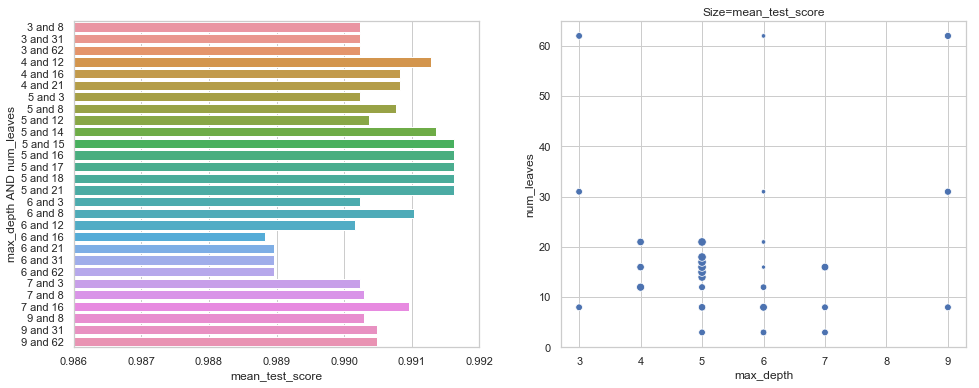

In [380]:
params_score_plot(result_df=result_df,xlim=[0.986,0.992])

In [199]:
x_index=[]
y_index=[]
for i in range(_.shape[0]):
    x_index.append(list(set(_['max_depth'].values)).index(_.loc[i,'max_depth']))
    y_index.append(list(set(_['num_leaves'].values)).index(_.loc[i,'num_leaves']))

In [265]:
from pyecharts import Scatter3D,Bar3D
range_color = [
    '#313695', '#4575b4', '#74add1', '#abd9e9', '#e0f3f8', '#ffffbf',
    '#fee090', '#fdae61', '#f46d43', '#d73027', '#a50026']
scatter3D = Scatter3D("3D 散点图示例", width=1200, height=600)
scatter3D.add("", result_df.values, is_visualmap=False, visual_range_color=range_color,zaxis3d_min=round(result_df['mean_test_score'].min(),3))
scatter3D

### pyspark

In [19]:
import findspark
findspark.init()
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext

In [2]:
sc = SparkContext()

In [4]:
sqlContext = SQLContext(sc)

In [13]:
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('./train_kj.csv')

In [28]:
data.show(1)

+------------------+----+-------+---------+------+-----------+---------+-----------+--------------+------------+-----------+---------------+--------+---------+----------+----------------+-------------+--------------+------------+------+-------------+---+---------+---------+----------+-----+------------+-----------+
|           LOAN_NO| age|channel|education|income|install_num|is_attach|is_fam_know|is_fam_reg_add|is_insuuance|is_reg_live|live_build_type|loan_amt|mar_level|mar_status|mobile_time_span|mth_repay_amt|mth_repay_date|mth_tel_bill|nation|no_close_loan|sex|str_level|unit_prov|unit_scale|FPD30|unit_is_live|reg_is_unit|
+------------------+----+-------+---------+------+-----------+---------+-----------+--------------+------------+-----------+---------------+--------+---------+----------+----------------+-------------+--------------+------------+------+-------------+---+---------+---------+----------+-----+------------+-----------+
|660002019031200146|18.0|    ΢��|     ����|7104.0

In [18]:
data.select(['income','install_num']).show(2)

+------+-----------+
|income|install_num|
+------+-----------+
|7104.0|        3.0|
|7105.0|        4.0|
+------+-----------+
only showing top 2 rows



In [22]:
data.select('income').printSchema()

root
 |-- income: double (nullable = true)



In [23]:
from pyspark.sql.functions import col

In [27]:
data.groupBy("install_num").count().orderBy(col("count").desc()).show()

+-----------+-----+
|install_num|count|
+-----------+-----+
|        3.0| 5890|
|        4.0| 4788|
|       12.0| 3366|
|        9.0| 2434|
|        6.0|   34|
+-----------+-----+



### impyute Knn fillna

In [4]:
from impyute.imputation.cs import fast_knn

In [8]:
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor

In [5]:
df = pd.DataFrame([[np.nan,2,np.nan,0],
                  [3,4,np.nan,1],
                  [np.nan,np.nan,np.nan,5],
                  [5,np.nan,8,10]],
                  columns = list('ABCD'))

In [7]:
imputed_training = fast_knn(df,k=2)
print(imputed_training)

          0         1    2     3
0  3.675500  2.000000  8.0   0.0
1  3.000000  4.000000  8.0   1.0
2  3.545837  2.908327  8.0   5.0
3  5.000000  3.645227  8.0  10.0


In [108]:
data = np.arange(25).reshape((5, 5)).astype(np.float)
data[1][2] =  np.nan

In [111]:
_=pd.DataFrame(data)

In [67]:
fast_knn(data,k=2)

array([[ 0.        ,  1.        , 10.08608891,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  7.        ,  8.        ,  9.        ],
       [10.        , 11.        , 12.        , 13.        , 14.        ],
       [15.        , 16.        , 17.        , 18.        , 19.        ],
       [20.        , 21.        , 22.        , 23.        , 24.        ]])

In [68]:
knnR = KNeighborsClassifier(n_neighbors=3)

In [69]:
knnR.fit(_.loc[[1,2,3,4],[0,1,3,4]].values,_.loc[[1,2,3,4],2])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [71]:
knnR.predict(_.loc[[0],[0,1,3,4]].values)

array([7.])

### apriori

In [29]:
from apyori import apriori

In [ ]:
data = [['豆奶','莴苣'],
        ['莴苣','尿布','葡萄酒','甜菜'],
        ['豆奶','尿布','葡萄酒','橙汁'],
        ['莴苣','豆奶','尿布','葡萄酒'],
        ['莴苣','豆奶','尿布','橙汁']]

In [68]:
result = apriori(transactions=train_kj[['channel','education','is_fam_know','sex','FPD30']].values,min_support=0.1,min_confidence=0.7)

In [71]:
l = train_kj[['channel','education','is_fam_know','sex','FPD30']].values.tolist()

In [ ]:
train_kj[['channel','education','is_fam_know','sex','FPD30']].values

In [69]:
list(result)

[RelationRecord(items=frozenset({'0'}), support=0.852531492248062, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'0'}), confidence=0.852531492248062, lift=1.0)]),
 RelationRecord(items=frozenset({'男'}), support=0.7136627906976745, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'男'}), confidence=0.7136627906976745, lift=1.0)]),
 RelationRecord(items=frozenset({'0', 'PC'}), support=0.4437984496124031, ordered_statistics=[OrderedStatistic(items_base=frozenset({'PC'}), items_add=frozenset({'0'}), confidence=0.8455059420791509, lift=0.9917591898565702)]),
 RelationRecord(items=frozenset({'0', '中专'}), support=0.16327519379844962, ordered_statistics=[OrderedStatistic(items_base=frozenset({'中专'}), items_add=frozenset({'0'}), confidence=0.852085967130215, lift=0.9994774091961434)]),
 RelationRecord(items=frozenset({'初中', '0'}), support=0.35828488372093026, ordered_statistics=[OrderedStatistic(items_base=frozenset({'初中'}), it

In [37]:
result[10]

RelationRecord(items=frozenset({'尿布', '豆奶'}), support=0.6, ordered_statistics=[OrderedStatistic(items_base=frozenset({'尿布'}), items_add=frozenset({'豆奶'}), confidence=0.7499999999999999, lift=0.9374999999999998), OrderedStatistic(items_base=frozenset({'豆奶'}), items_add=frozenset({'尿布'}), confidence=0.7499999999999999, lift=0.9374999999999998)])

### IsolationForest

In [290]:
from sklearn.ensemble import IsolationForest

In [291]:
lsf = IsolationForest(random_state=0,n_estimators=1000,n_jobs=-1)

In [235]:
_=pd.concat([train_kj[['age',
  'income',
  'install_num',
  'is_attach',
  'is_insuuance',
  'loan_amt',
  'mobile_time_span',
  'mth_repay_amt',
  'mth_repay_date',
  'no_close_loan',
  'str_level',
  'unit_is_live',
  'reg_is_unit']],pd.get_dummies(train_kj[['channel',
  'education',
  'is_fam_know',
  'is_fam_reg_add',
  'is_reg_live',
  'live_build_type',
  'mar_level',
  'mar_status',
  'mth_tel_bill',
  'nation',
  'sex',
  'unit_prov',
  'unit_scale']])],axis=1)

In [292]:
lsf.fit(train_kj[['age',
  'income',
  'install_num',
  'loan_amt',
  'mobile_time_span',
  'mth_repay_amt',
  'mth_repay_date']].values)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=1000, n_jobs=-1, random_state=0,
        verbose=0)

In [272]:
score = lsf.decision_function(_.astype(float).values)

In [293]:
_=lsf.predict(train_kj[['age',
  'income',
  'install_num',
  'loan_amt',
  'mobile_time_span',
  'mth_repay_amt',
  'mth_repay_date']].values)

In [294]:
pred = pd.Series(_,index=train_kj.index)

In [295]:
pred.name='iforest'

In [296]:
pred.value_counts()

 1    14860
-1     1652
Name: iforest, dtype: int64

In [297]:
train_kj.FPD30.value_counts()

0.0    14077
1.0     2435
Name: FPD30, dtype: int64

In [298]:
pred_c = pd.concat([train_kj.FPD30,pred],axis=1)

In [299]:
pred_c.groupby(['FPD30','iforest']).size().unstack()

iforest,-1,1
FPD30,,
0.0,1551,12526
1.0,101,2334


In [83]:
_=lsf.predict(train_kj[['age','income']].iloc[10000:].astype(float).values)

In [93]:
train_kj.index

RangeIndex(start=0, stop=16512, step=1)

In [97]:
train_kj.iloc[[-3]][['age','income']]

,age,income
16509,20.0,2500.0


In [100]:
train_kj[['age','income']].iloc[-3:]

,age,income
16509,20.0,2500.0
16510,24.0,7104.0
16511,31.0,7104.0


In [ ]:
train_kj[['age','income']].iloc[10000:]

In [106]:
out_index=[]
for i,k in enumerate(_):
    if k==-1:
        out_index.append(i+10000)

In [107]:
len(out_index)

652

In [137]:
age_income = train_kj[['age','income']].loc[10000:]

In [141]:
age_income['out']  = 0

In [142]:
age_income.loc[out_index,'out']=1

In [143]:
age_income=age_income.astype(float)

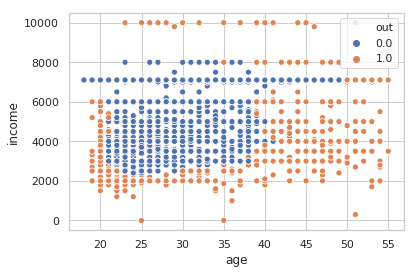

In [144]:
sns.scatterplot(data=age_income,x='age',y='income',hue='out')

### tensorflow

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
print(tf.__version__)

1.9.0


In [4]:
# 导入数据集
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

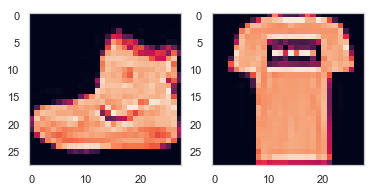

In [13]:

plt.subplot(1,2,1)
plt.imshow(train_images[0])
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(train_images[1])
plt.grid(False)

In [6]:
train_images = train_images/255
test_images = test_images/255

In [32]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [33]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [34]:
model.fit(x=train_images,y=train_labels,epochs=10)

Epoch 1/10
60000/60000 [==============================] - 8s 127us/step - loss: 0.5005 - acc: 0.8234
Epoch 2/10
60000/60000 [==============================] - 6s 94us/step - loss: 0.3812 - acc: 0.8621
Epoch 3/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.3388 - acc: 0.8766
Epoch 4/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.3155 - acc: 0.8839
Epoch 5/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.2966 - acc: 0.8904
Epoch 6/10
60000/60000 [==============================] - 6s 99us/step - loss: 0.2822 - acc: 0.8954
Epoch 7/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.2668 - acc: 0.9011
Epoch 8/10
60000/60000 [==============================] - 6s 102us/step - loss: 0.2580 - acc: 0.9040
Epoch 9/10
60000/60000 [==============================] - 6s 105us/step - loss: 0.2476 - acc: 0.9077
Epoch 10/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.2388 - acc: 

In [37]:
a,b = model.evaluate(test_images,test_labels)
print('accuracy:%s'%b)

10000/10000 [==============================] - 0s 31us/step
accuracy:0.8849


In [47]:
np.argmax(model.predict(test_images)[0])

9

In [65]:
model.predict(np.expand_dims(test_images[0],0))

array([[2.4026388e-06, 2.6423947e-09, 8.7004537e-07, 1.8889486e-06,
        4.9731705e-07, 4.1201324e-04, 3.6711551e-06, 1.2475329e-02,
        9.3390099e-06, 9.8709399e-01]], dtype=float32)

## DEF

In [234]:
def feature_count_ratio(data,x,xtype,y,value):
    '''单个特征-Y值分布统计。y为float型，取值0和1。x为float(数值型)或object(类别型)。xtype:"numeric"或其他。value:统计值，如"LOAN_NO"
    return style形式dataframe 和 overlap'''
    counts_ratio=pd.pivot_table(data=data[[x,y,value]],values=value,index=x,columns=y,aggfunc=len,margins=True,fill_value=0)
    counts_ratio['one_ratio'] = counts_ratio[1].div(counts_ratio['All'])
    counts_ratio = counts_ratio.drop(counts_ratio.index[-1])
    if xtype != 'numeric':
        counts_ratio = counts_ratio.sort_values('one_ratio')
    bar = Bar(x,title_pos='center')
    line = Line()
    x_len = len(counts_ratio.index)
    rotate = 0 if x_len < 15 else 45 if x_len < 30 else 90
    bar.add('count', counts_ratio.index, counts_ratio['All'].values, yaxis_min=0, yaxis_max=None, is_label_show=False, label_pos='inside',
             legend_pos='right', legend_orient='vertical',is_stack=False,label_color=['#35b0ab'],xaxis_rotate=rotate)
    line.add('y=1', counts_ratio.index, counts_ratio['one_ratio'].values, yaxis_min=0, yaxis_max=None, is_label_show=False, label_pos='inside',
             legend_pos='right', legend_orient='vertical',is_stack=False,label_color=['#f34573'],line_width=1.5,is_smooth=False)
    overlap = Overlap(width='100%')
    overlap.add(bar)
    overlap.add(line,is_add_yaxis=True,yaxis_index=1)
    return counts_ratio.style.bar(subset=['All','one_ratio']), overlap

In [275]:
def get_woe_iv(df,x,x_type,y,only_total_iv=False,style=True,sort=False):
    '''单个变量WOE和IV值计算。return df 和 overlap。only_total_iv=True时只return总IV。'''
    df_concat=df[[x,y]]    
    df_concat[y] = df_concat[y].apply(float)
    x_values=list(df_concat[x].unique())
    if x_type == 'numeric':
        x_values.sort()
    s_total=df_concat.groupby(y).size()
    woe_dic={}
    iv_dic={}
    total_iv=0
    for i in range(len(x_values)):
        a=df_concat[df_concat[x]==x_values[i]].groupby(y).size()
        aa=a.to_dict()
        for k in [0,1]:
            if aa.get(k,'null') == 'null':
                aa[k]=1
        a=pd.Series(aa)
        respand_rate=a[1]/s_total[1]
        norespand_rate=a[0]/s_total[0]
        rate=respand_rate/norespand_rate
        woe=math.log(rate,math.e)
        iv=(a[1]/s_total[1]-a[0]/s_total[0])*woe
        total_iv += iv
        woe_dic[x_values[i]]=woe
        iv_dic[x_values[i]]=iv
    df_woe_iv=pd.DataFrame({x+'_WOE':woe_dic,x+'_IV':iv_dic}).T
    x_pivot=df_concat.groupby(y)[x].apply(Counter)
    x_pivot=x_pivot.unstack().T
    x_pivot.fillna(0,inplace=True)
    x_pivot['样本总量']=x_pivot[0]+x_pivot[1]
    x_pivot['坏样本占比']=x_pivot[1]/x_pivot['样本总量']
    x_des_woe_iv=pd.concat([x_pivot,df_woe_iv.T],axis=1)
    if sort:
        x_des_woe_iv = x_des_woe_iv.sort_values(by='坏样本占比')
    if not only_total_iv:
        bar = Bar(x,title_pos='center')  # 绘图
        line = Line()
        x_len = len(x_des_woe_iv.index)
        rotate = 0 if x_len < 15 else 45 if x_len < 30 else 90
        bar.add('count', x_des_woe_iv.index, x_des_woe_iv['样本总量'].values, yaxis_min=0, yaxis_max=None, is_label_show=False, label_pos='inside',
                 legend_pos='right', legend_orient='vertical',is_stack=False,label_color=['#35b0ab'],xaxis_rotate=rotate)
        line.add('bad_ratio', x_des_woe_iv.index, x_des_woe_iv['坏样本占比'].values, yaxis_min=0, yaxis_max=None, is_label_show=False, label_pos='inside',
                 legend_pos='right', legend_orient='vertical',is_stack=False,label_color=['#f34573'],line_width=1.5,is_smooth=False)
        overlap = Overlap(width='100%')
        overlap.add(bar)
        overlap.add(line,is_add_yaxis=True,yaxis_index=1)
    if only_total_iv:
        return total_iv
    else:
        print('total IV of {} is: {}'.format(x,total_iv))
        if style:
            return x_des_woe_iv.style.bar(subset=['样本总量','坏样本占比',x+'_IV',x+'_WOE']), overlap
        else:
            return x_des_woe_iv, overlap

In [3]:
class featureCountsDraw():
    '''特征与坏账统计。绘图。pyecharts'''
    def __init__(self):
        pass
    def onevar(self,data,x_index,y_index):
        '''统计函数
        param
            data：frame 数据源
            x_index：int 特征所在列索引
            y_index: int 目标所在列索引
        return
            A: frame
        '''            
        A=pd.DataFrame(data.groupby(data.columns[x_index],as_index=False).size())
        A.columns=['单量']
        B=data[data.iloc[:,y_index]=='1'].groupby(data.columns[x_index]).size()
        A['坏账']=B
        A=A.reset_index()
        A['好客户']=list(map(lambda x,y:x-y,A['单量'],A['坏账']))    
        A['坏账率']=list(map(lambda x,y:round(x/y,4),A['坏账'],A['单量']))
        A['总体坏账率']=round(A['坏账'].sum()/A['单量'].sum(),4)
        A=A.applymap(lambda x:x if pd.notnull(x) else 0)
        return A
    def drawfunc(self,A,text,yaxis_max=200000,yaxis_force_interval=0.25,width=1000):
        '''坏账率绘图函数'''
        from pyecharts import Bar,Line,Overlap,Grid,Page
        bar = Bar(text,title_pos='center',width='100%')  
        line = Line(text,title_pos='center',width='100%') 
        bar.add("好客户",A.iloc[:,0].tolist(),A['好客户'].tolist(),yaxis_min=0,yaxis_max=yaxis_max,is_label_show=True,label_pos='inside',
                label_color=['#FFB6B9'],legend_pos='right', legend_orient='vertical',is_stack=True)
        bar.add("坏客户",A.iloc[:,0].tolist(),A['坏账'].tolist(),yaxis_min=0,yaxis_max=yaxis_max,is_label_show=True,label_pos='inside',
                label_color=['#BBDED6'],legend_pos='right',legend_orient='vertical',is_stack=True) 
        line.add('坏账率',A.iloc[:,0].tolist(),A['坏账率'].tolist(),yaxis_min=0,yaxis_max=1,yaxis_force_interval=yaxis_force_interval,is_smooth=True,
                legend_pos='right',point_symbol='circle',legend_orient='vertical',line_width =2,is_label_show =True)
        line.add('总体坏账率',A.iloc[:,0].tolist(),A['总体坏账率'].tolist(),yaxis_min=0,yaxis_max=1,yaxis_force_interval=yaxis_force_interval,is_smooth=True,
                legend_pos='right',legend_orient='vertical',line_width =2,line_type='dotted')
        overlap = Overlap(width='100%')
        overlap.add(bar)
        overlap.add(line,is_add_yaxis=True,yaxis_index=1) 
        grid=Grid(width=width)
        grid.add(overlap,grid_right='10%')
        return grid

In [187]:
def divide_x_dtype(df):
    """
    划分变量数据类型
    注：缺失值需为np.nan
    """
    int_X=[]
    float_X=[]
    category_X=[]
    for i,ds in df.iteritems():
        ds = ds[ds.notnull()]
        try:
            ds = ds.apply(float)
        except:
            category_X.append(i)
        finally:
            if i not in category_X:
                ds_re = ds.apply(lambda x: x%1)
                if ds_re.max()==0:
                    int_X.append(i)
                else:
                    float_X.append(i)
    return {'int':int_X,'float':float_X,'category':category_X}